# Parte 01 - Otimização Numérica

## 1. O Problema: Quando a Solução Analítica Falha

Em muitos problemas estatísticos, encontrar o Estimador de Máxima Verossimilhança (EMV) envolve derivar a função de log-verossimilhança, igualá-la a zero e resolver para o parâmetro $\theta$. No entanto, para muitas distribuições, a equação resultante não tem uma solução analítica ("fechada").

**Estudo de Caso: A Distribuição Gama**

Seja $Z_1, ..., Z_n$ uma amostra aleatória de uma população $Z \sim \text{Gama}(\text{shape}=\theta, \text{scale}=1)$.
A função de log-verossimilhança é:
$$l(\theta|z_n) = (\theta-1)\sum_{i=1}^{n}\log(z_i) - \sum_{i=1}^{n}z_i - n \log(\Gamma(\theta))$$
A função escore (derivada) é:
$$\frac{\partial l}{\partial \theta} = \sum_{i=1}^{n}\log(z_i) - n \psi(\theta)$$
onde $\psi(\theta) = \frac{d}{d\theta}\log(\Gamma(\theta))$ é a **função digama**.

O EMV, $\hat{\theta}_{MV}$, é a solução da equação $\overline{\log(Z)} = \psi(\hat{\theta}_{MV})$. Não podemos isolar $\hat{\theta}$ algebricamente. Portanto, precisamos de **métodos numéricos de otimização** para encontrar a estimativa.

## 2. Métodos Numéricos de Otimização

Vamos comparar três algoritmos para encontrar $\hat{\theta}_{MV}$ a partir de uma amostra simulada.

In [3]:
knitr::opts_chunk$set(echo = TRUE, message = FALSE, warning = FALSE)
library(cli)

# Gerar uma amostra para usar nos exemplos
set.seed(123)
n = 100
theta0 = 10
x = rgamma(n, shape = theta0, scale = 1)

# Chute inicial para os algoritmos: Estimativa via Método de Momentos
# Para a Gama(theta, 1), E[X]=theta e Var(X)=theta. Usamos a média.
chute_inicial = mean(x)

### 2.1 Método de Newton-Raphson (NR)

[cite_start]O Newton-Raphson é um método de segunda ordem, o que significa que ele usa a informação da primeira e da segunda derivada (a curvatura) para convergir rapidamente. [cite: 369-371] A regra de atualização é:
$$\theta_{j+1} = \theta_j - [l''(\theta_j)]^{-1} l'(\theta_j)$$
Para a Gama, $l''(\theta) = -n \psi_1(\theta)$, onde $\psi_1$ é a **função trigama**.

In [4]:
theta.hat = numeric(100)
theta.hat[1] = chute_inicial
erro = 1
j = 1

# Derivadas em R: digamma() para a 1ª, trigamma() para a 2ª
score_func = function(theta, data) { sum(log(data)) - length(data) * digamma(theta) }
hessian_func = function(theta, data) { -length(data) * trigamma(theta) }

while (erro > 10^(-5)) {
  j = j + 1
  # Aplica a regra de atualização do NR
  theta.hat[j] = theta.hat[j-1] - score_func(theta.hat[j-1], x) / hessian_func(theta.hat[j-1], x)
  erro = abs(theta.hat[j] - theta.hat[j-1])
  cat("NR Iteration:", j-1, ", theta.hat=", round(theta.hat[j], 4), "\n")
}
theta_nr = theta.hat[j]

NR Iteration: 1 , theta.hat= 9.9202 
NR Iteration: 2 , theta.hat= 9.9212 
NR Iteration: 3 , theta.hat= 9.9212 


**Análise:** O Newton-Raphson converge em pouquíssimas iterações. [cite_start]É muito rápido, mas seu custo computacional por iteração é alto, pois requer o cálculo da segunda derivada. [cite: 377, 379]

### 2.2 Gradient Descent (GD)

[cite_start]O Gradient Descent é um método de primeira ordem que usa apenas a informação do gradiente (a primeira derivada). [cite: 355] A regra de atualização é:
$$\theta_{j+1} = \theta_j + \delta \cdot l'(\theta_j)$$
onde $\delta$ é a **taxa de aprendizado (learning rate)**.

In [5]:
theta.hat = numeric(1000)
theta.hat[1] = chute_inicial
erro = 1
j = 1
delta = 0.0001 # A taxa de aprendizado precisa ser pequena e ajustada cuidadosamente

while (erro > 10^(-5)) {
  j = j + 1
  # Aplica a regra de atualização do GD
  theta.hat[j] = theta.hat[j] + delta * score_func(theta.hat[j-1], x)
  erro = abs(theta.hat[j] - theta.hat[j-1])
  if (j %% 100 == 0) { # Imprime a cada 100 iterações
    cat("GD Iteration:", j-1, ", theta.hat=", round(theta.hat[j], 4), "\n")
  }
  if (j >= 999) break # Critério de parada para evitar loop infinito
}
theta_gd = theta.hat[j]
cat("GD Final Iteration:", j-1, ", theta.hat=", round(theta.hat[j], 4), "\n")

GD Final Iteration: 49 , theta.hat= 0.1141 


**Análise:** O GD requer muito mais iterações para convergir. [cite_start]Sua convergência não é garantida e depende criticamente da escolha da taxa de aprendizado $\delta$. [cite: 353-354] No entanto, cada iteração é computacionalmente mais barata que a do NR.

### 2.3 Stochastic Gradient Descent (SGD)

[cite_start]O SGD é uma variação do GD que aproxima o gradiente usando apenas um subconjunto de dados (um "mini-batch") em cada passo. [cite: 339-340] No exemplo da aula, usamos o caso extremo com **batch size = 1**, onde a atualização é feita para cada observação individualmente.

In [6]:
theta.hat = numeric()
theta.hat[1] = chute_inicial
erro = 1
k = 0 # Contador de épocas (passagens completas pelos dados)
j = 1 # Contador de iterações totais
delta = 0.001 # Taxa de aprendizado para SGD

while (erro > 10^(-5) && k < 50) {
  k = k + 1 # Nova época
  for (i in 1:n) {
    j = j + 1
    # Gradiente estocástico (usando apenas a observação x[i])
    grad_stochastic = log(x[i]) - digamma(theta.hat[j-1])
    # Aplica a regra de atualização do SGD
    theta.hat[j] = theta.hat[j-1] + delta * grad_stochastic
  }
  # O erro é verificado apenas no final de cada época
  erro = abs(theta.hat[j] - theta.hat[j-n]) 
  cat("Época:", k, ", theta.hat=", round(theta.hat[j], 4), "\n")
}
theta_sgd = theta.hat[j]

Época: 1 , theta.hat= 9.7862 
Época: 2 , theta.hat= 9.7876 
Época: 3 , theta.hat= 9.7891 
Época: 4 , theta.hat= 9.7905 
Época: 5 , theta.hat= 9.7919 
Época: 6 , theta.hat= 9.7933 
Época: 7 , theta.hat= 9.7947 
Época: 8 , theta.hat= 9.796 
Época: 9 , theta.hat= 9.7974 
Época: 10 , theta.hat= 9.7987 
Época: 11 , theta.hat= 9.8 
Época: 12 , theta.hat= 9.8013 
Época: 13 , theta.hat= 9.8026 
Época: 14 , theta.hat= 9.8039 
Época: 15 , theta.hat= 9.8052 
Época: 16 , theta.hat= 9.8064 
Época: 17 , theta.hat= 9.8076 
Época: 18 , theta.hat= 9.8089 
Época: 19 , theta.hat= 9.8101 
Época: 20 , theta.hat= 9.8113 
Época: 21 , theta.hat= 9.8125 
Época: 22 , theta.hat= 9.8136 
Época: 23 , theta.hat= 9.8148 
Época: 24 , theta.hat= 9.8159 
Época: 25 , theta.hat= 9.8171 
Época: 26 , theta.hat= 9.8182 
Época: 27 , theta.hat= 9.8193 
Época: 28 , theta.hat= 9.8204 
Época: 29 , theta.hat= 9.8215 
Época: 30 , theta.hat= 9.8226 
Época: 31 , theta.hat= 9.8236 
Época: 32 , theta.hat= 9.8247 
Época: 33 , theta.hat

**Análise:** O SGD realiza atualizações muito "ruidosas", mas computacionalmente muito baratas. [cite_start]É o método de escolha para problemas de larga escala (muitos dados e/ou muitos parâmetros), como o treinamento de redes neurais profundas. [cite: 334]

## 3. Resumo e Próximos Passos: Intervalos de Confiança

A escolha do método de otimização é um trade-off entre custo computacional por iteração e velocidade de convergência.
* **NR:** Rápido, mas caro. Ideal para problemas de baixa dimensão.
* **GD/SGD:** Lento, mas barato. Essencial para problemas de alta dimensão.
* [cite_start]**Avançados (e.g., ADAM):** Métodos como ADAM [cite: 343] são adaptativos e tentam combinar o melhor dos dois mundos, sendo o padrão em muitas aplicações modernas de aprendizado de máquina.

Agora que temos métodos robustos para encontrar a **estimativa pontual** $\hat{\theta}_{MV}$, o próximo passo da inferência estatística é quantificar a incerteza dessa estimativa. Para isso, construímos **Regiões (ou Intervalos) de Confiança**.


# Parte 02 - Intervalo de Confiança

## 4. Quantificando a Incerteza: Intervalos de Confiança Assintóticos

Uma estimativa pontual, como $\hat{\theta}_{MV}$, nos dá o valor mais plausível para o parâmetro, mas não informa nada sobre a incerteza associada a essa estimativa. Para isso, construímos **Intervalos de Confiança**.

[cite_start]Um intervalo de confiança com coeficiente de confiança $\gamma$ (e.g., 95%) é uma região aleatória que, antes da coleta dos dados, tem probabilidade $\gamma$ de conter o verdadeiro valor do parâmetro. [cite: 273, 274] A confiança está no *procedimento*, não em um intervalo específico já observado.

### 4.1 O Intervalo de Confiança de Wald

Um método geral para construir regiões de confiança assintóticas é baseado na **Estatística de Wald**. [cite_start]Conforme a teoria (Teorema 2.4.1 e suas consequências), se temos um estimador assintoticamente normal $\hat{\theta}_n$, podemos construir a seguinte quantidade: [cite: 565]

$$Q_n(\theta) = n(\hat{\theta}_n - \theta)^\top [V_{\hat{\theta}_n}]^{-1} (\hat{\theta}_n - \theta) \xrightarrow{D} \chi^2_p$$

[cite_start]Onde $p$ é a dimensão de $\theta$ e $V_{\hat{\theta}_n}$ é uma estimativa consistente da variância assintótica. [cite: 238, 245]

[cite_start]Uma região de confiança de nível $\gamma$ é então o conjunto de todos os valores de $\theta$ para os quais a estatística $Q_n(\theta)$ observada não é "extrema", ou seja: [cite: 241]

$$C_\gamma(Z_n) = \{\theta \in \Theta : Q_n(\theta) \le q_{\gamma, p}\}$$

Onde $q_{\gamma, p}$ é o quantil $\gamma$ de uma distribuição $\chi^2_p$.

#### Aplicação para a Poisson($\theta$)

Para o EMV da Poisson, $\hat{\theta}_n = \overline{Z}$, temos $p=1$ e a variância assintótica é $\theta$, que podemos estimar por $\hat{\theta}_n = \overline{Z}$. A estatística de Wald se torna:

$$Q_n(\theta) = n(\overline{Z} - \theta)^2 / \overline{Z} \approx \chi^2_1$$

[cite_start]O intervalo de confiança é derivado da inequação $Q_n(\theta) \le q_{\gamma, 1}$: [cite: 223]
$$n\frac{(\overline{Z} - \theta)^2}{\overline{Z}} \le q_{\gamma, 1} \implies (\overline{Z} - \theta)^2 \le \frac{q_{\gamma, 1}\overline{Z}}{n}$$
$$\implies |\overline{Z} - \theta| \le \sqrt{\frac{q_{\gamma, 1}\overline{Z}}{n}}$$
$$\implies \overline{Z} - \sqrt{\frac{q_{\gamma, 1}\overline{Z}}{n}} \le \theta \le \overline{Z} + \sqrt{\frac{q_{\gamma, 1}\overline{Z}}{n}}$$

Este é o **Intervalo de Confiança de Wald** para $\theta$.

## 5. Cobertura Nominal vs. Cobertura Real

A teoria nos diz que, quando $n \to \infty$, a probabilidade de o intervalo de Wald conter o verdadeiro $\theta$ é de 95% (a **cobertura nominal**). Mas como ele se comporta para um `n` finito? A **cobertura real (ou empírica)** pode ser diferente.

Vamos usar uma simulação de Monte Carlo para estimar a cobertura real do intervalo de Wald para diferentes tamanhos de amostra `n`, replicando a análise da aula.

### Simulação: Estudando o Comportamento da Cobertura

O objetivo é verificar se a "confiança de que 95% dos intervalos observados vão conter o $\theta$ certo" se sustenta na prática.

In [7]:
knitr::opts_chunk$set(echo = TRUE, message = FALSE, warning = FALSE)
library(cli)

n = 2, Cobertura Real Atingida = 0.9274

n = 5, Cobertura Real Atingida = 0.9419

n = 10, Cobertura Real Atingida = 0.9456

n = 20, Cobertura Real Atingida = 0.9498

n = 50, Cobertura Real Atingida = 0.9528

n = 100, Cobertura Real Atingida = 0.9488

n = 200, Cobertura Real Atingida = 0.9546

n = 300, Cobertura Real Atingida = 0.9519

n = 500, Cobertura Real Atingida = 0.9511



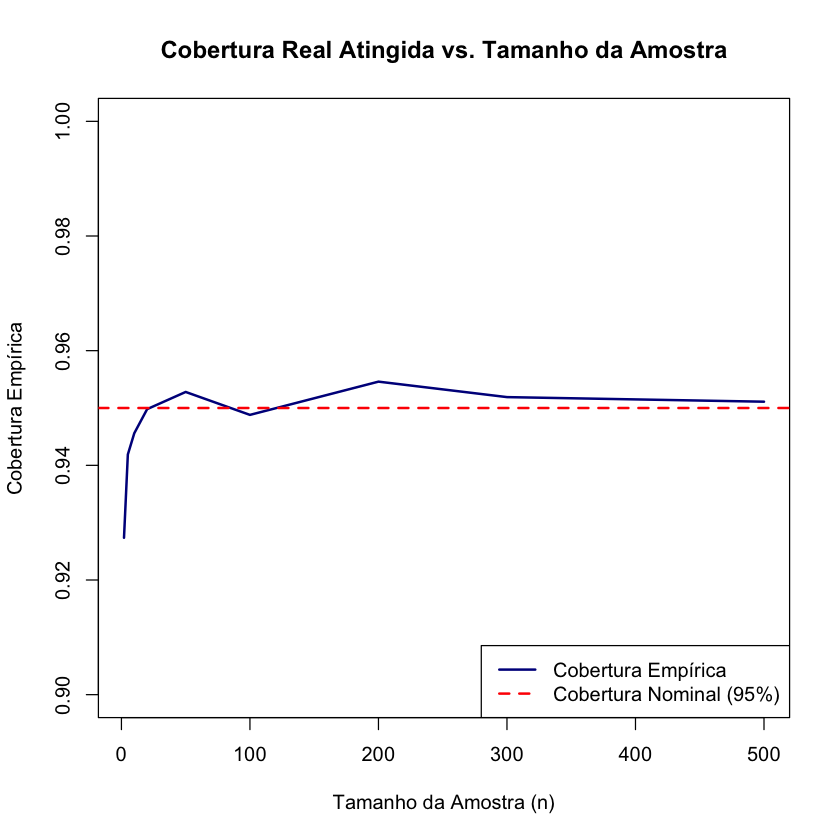

In [8]:
# 1. Parâmetros da simulação
set.seed(42)
# Vetor de tamanhos amostrais a serem testados
nn = c(2, 5, 10, 20, 50, 100, 200, 300, 500) 
MC = 10000 # Número de réplicas de Monte Carlo
gamma = 0.95 # Nível de confiança nominal

# Vetor para armazenar a cobertura empírica para cada n
A = numeric(length(nn))
Fgamma1 = qchisq(gamma, 1) # Quantil da Chi-quadrado, ~3.84

# 2. Loop externo: itera sobre os tamanhos de amostra
for (j in 1:length(nn)) {
  n = nn[j]
  cober = numeric(MC) # Vetor para os resultados de cobertura da simulação interna
  
  # 3. Loop interno: simulação de Monte Carlo para um n fixo
  for (i in 1:MC) {
    # Geramos o theta0 aleatoriamente para testar a robustez
    theta0 = runif(1, 1, 10)
    
    # Gerando dados sob H0 (com o theta0 verdadeiro)
    x = rpois(n, theta0)
    mean_x = mean(x)
    
    # Prevenção de divisão por zero se mean_x for 0
    if (mean_x <= 0) {
      cober[i] = NA
      next
    }
    
    # Calculando os limites do intervalo de Wald
    margem_erro = sqrt(Fgamma1 * mean_x / n)
    I1 = mean_x - margem_erro
    I2 = mean_x + margem_erro
    
    # Verificando se o intervalo cobriu o theta0 verdadeiro
    cober[i] = ifelse(I1 <= theta0 & I2 >= theta0, 1, 0)
  }
  
  # 4. Armazenando a cobertura empírica média para o n atual
  A[j] = mean(cober, na.rm = TRUE)
  cli_progress_message(paste0("n = ", n, ", Cobertura Real Atingida = ", round(A[j], 4)))
}

# 5. Visualização dos Resultados
plot(nn, A, 
     type = "l", # 'l' para linha
     lwd = 2,
     col = "darkblue",
     ylim = c(min(A, 0.90), 1),
     xlab = "Tamanho da Amostra (n)",
     ylab = "Cobertura Empírica",
     main = "Cobertura Real Atingida vs. Tamanho da Amostra")

# Adiciona uma linha de referência no nível nominal
abline(h = gamma, col = "red", lty = 2, lwd = 2)
legend("bottomright", legend = c("Cobertura Empírica", "Cobertura Nominal (95%)"),
       col = c("darkblue", "red"), lty = c(1, 2), lwd = 2)

### Análise dos Resultados

O gráfico gerado é a principal conclusão da aula sobre intervalos de confiança assintóticos. Ele mostra claramente que:

* **Para amostras pequenas (`n` baixo):** A cobertura real atingida fica **significativamente abaixo** da cobertura nominal de 95%. Isso significa que, se usarmos o intervalo de Wald com poucos dados, ele será "liberal" demais e conterá o parâmetro verdadeiro com menos frequência do que o prometido.
* **À medida que `n` aumenta:** A cobertura real converge para a cobertura nominal. A aproximação assintótica se torna cada vez melhor, e a promessa dos 95% de confiança se torna mais confiável.

Isso ilustra uma lição fundamental em inferência estatística: as propriedades teóricas dos métodos assintóticos são garantias que se tornam mais precisas à medida que o tamanho da amostra cresce. A simulação de Monte Carlo é a nossa ferramenta para diagnosticar o quão bem essas propriedades se aplicam a um problema com um tamanho de amostra finito.